# Lesson 1 - ImageNet pretrained ResNet34 with CUB-200 birds dataset

In this notebook pretrained ResNet34 is trained on the CUB-200 birds dataset.<br><br>
The dataset website (http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz) shows this warning:<br>
<font color=red>Warning: Images in this dataset overlap with images in ImageNet. Exercise caution when using networks pretrained with ImageNet (or any network pretrained with images from Flickr) as the test set of CUB may overlap with the training set of the original network.</font><br><br>
Therefore, this notebook closely evalutes the impact of a ImageNet pretrained ResNet with another dataset that incorporates pictures from the pretraining dataset.

## Notebook setup

In [1]:
# notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai library
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path to data directory
path = Path('/home/paperspace/fastai/data/CUB-200')

### Download data

In [4]:
# get CUB-200 dataset
#!wget http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz

### Dataframe setup

In [5]:
# read in text file with a list of all the files
df = pd.read_csv(path/'lists/files.txt', sep=' ', header=None, names=['imgurl'])

In [6]:
# test of string manipulation to get the data class
#('001.Black_footed_Albatross/Black_footed_Albatross_0001_2950163169.jpg').split('.')[1].split('/')[0]

In [7]:
# define string manipulation lambda function to get data class
f = lambda x: x.split('.')[1].split('/')[0]
df['class'] = df['imgurl'].apply(f)

In [8]:
# verify dataframe
df.head()

,imgurl,class
0,001.Black_footed_Albatross/Black_footed_Albatr...,Black_footed_Albatross
1,001.Black_footed_Albatross/Black_footed_Albatr...,Black_footed_Albatross
2,001.Black_footed_Albatross/Black_footed_Albatr...,Black_footed_Albatross
3,001.Black_footed_Albatross/Black_footed_Albatr...,Black_footed_Albatross
4,001.Black_footed_Albatross/Black_footed_Albatr...,Black_footed_Albatross


In [9]:
df.tail()

,imgurl,class
6028,200.Common_Yellowthroat/Common_Yellowthroat_00...,Common_Yellowthroat
6029,200.Common_Yellowthroat/Common_Yellowthroat_00...,Common_Yellowthroat
6030,200.Common_Yellowthroat/Common_Yellowthroat_00...,Common_Yellowthroat
6031,200.Common_Yellowthroat/Common_Yellowthroat_00...,Common_Yellowthroat
6032,200.Common_Yellowthroat/Common_Yellowthroat_00...,Common_Yellowthroat


### ImageDataBunch setup

In [10]:
size = 224 # image size used for training (Note: is only applied when ds_tfms are set)
bs = 64 # batchsize for training

In [11]:
data = ImageDataBunch.from_df(path/'images/', df, ds_tfms=get_transforms(), size=size, bs=bs)

In [12]:
# normalize data with the imagent_stats
data.normalize(imagenet_stats)

In [13]:
# verify ImageDataBunch setup
data.path

PosixPath('/home/paperspace/fastai/data/CUB-200/images')

In [14]:
# check if dataset classes equal datatset class count
len(data.train_ds.classes), data.train_ds.c

(200, 200)

### Data exploration

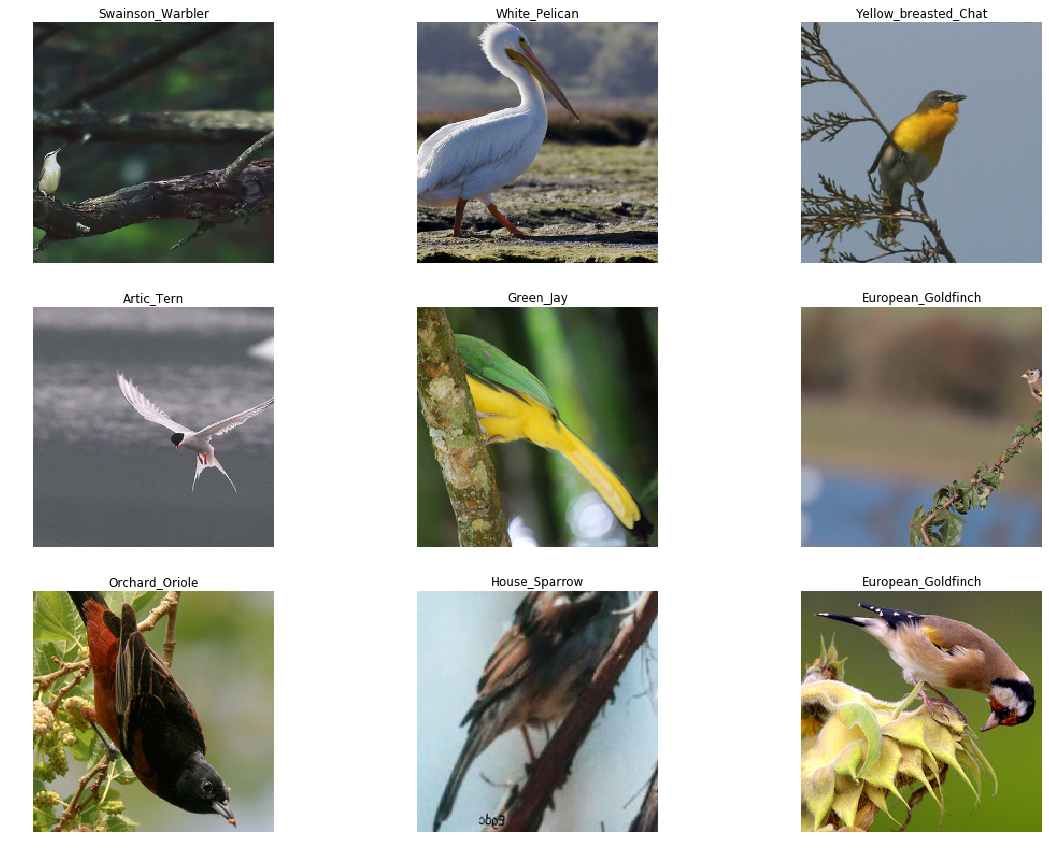

In [15]:
data.show_batch(rows=3, figsize=(17,12))

## Learner setup

In [16]:
# setup learner with ResNet34 and accuracy metric (the entire NN is froozen except the last layers fro classification)
learn = ConvLearner(data, models.resnet34, metrics=accuracy)

## Stage 1 - Training

In [30]:
!gpustat

psbtmxtmo  Fri Oct 26 15:01:42 2018
[0] Quadro P4000     | 59'C,   0 % |  7270 /  8119 MB | paperspace(4445M) paperspace(2815M)


In [17]:
# run learning rate finder to get optimal learning rate
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


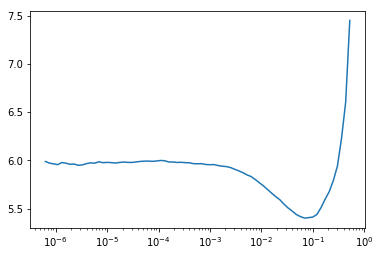

In [18]:
learn.recorder.plot()

In [20]:
lr = 1e-2

In [21]:
# fit with one cycle policy for 12 epochs
learn.fit_one_cycle(12, max_lr=lr)

Total time: 07:23
epoch  train_loss  valid_loss  accuracy
1      4.474658    2.893872    0.345658  (00:42)
2      2.745218    1.926280    0.487532  (00:39)
3      2.227118    2.290484    0.417025  (00:35)
4      2.178989    2.289257    0.441960  (00:27)
5      1.941701    1.850553    0.503869  (00:40)
6      1.696679    1.582852    0.580396  (00:38)
7      1.465068    1.463282    0.609630  (00:30)
8      1.208591    1.257529    0.650903  (00:39)
9      0.947111    1.116786    0.693895  (00:36)
10     0.738056    1.057844    0.699054  (00:37)
11     0.595673    1.028277    0.701634  (00:38)
12     0.537695    1.029746    0.711952  (00:36)



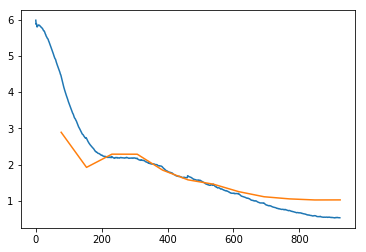

In [24]:
# plot learning
learn.recorder.plot_losses()

In [25]:
# save trained model
learn.save('birds_resnet34_stage_1')

## Stage 1 - Interpretation

In [26]:
# classification interpretation
interp = ClassificationInterpretation.from_learner(learn)

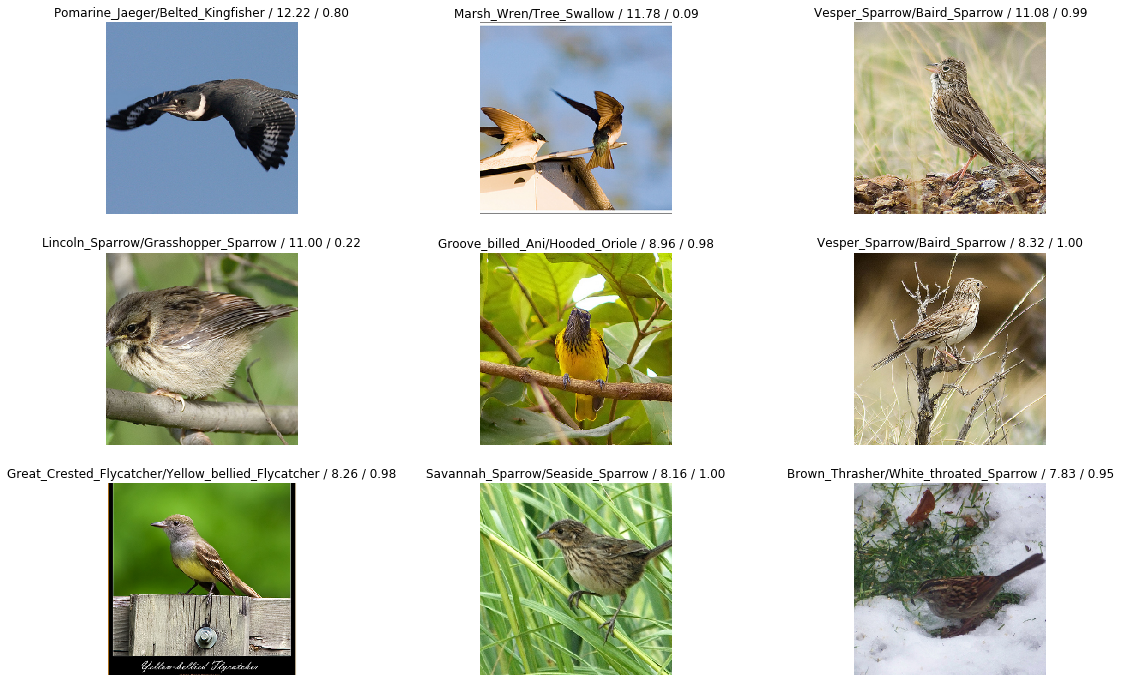

In [27]:
# show images with top_losses including their prediction, actual, loss, and probability of actual class
interp.plot_top_losses(9, figsize=(19,12))

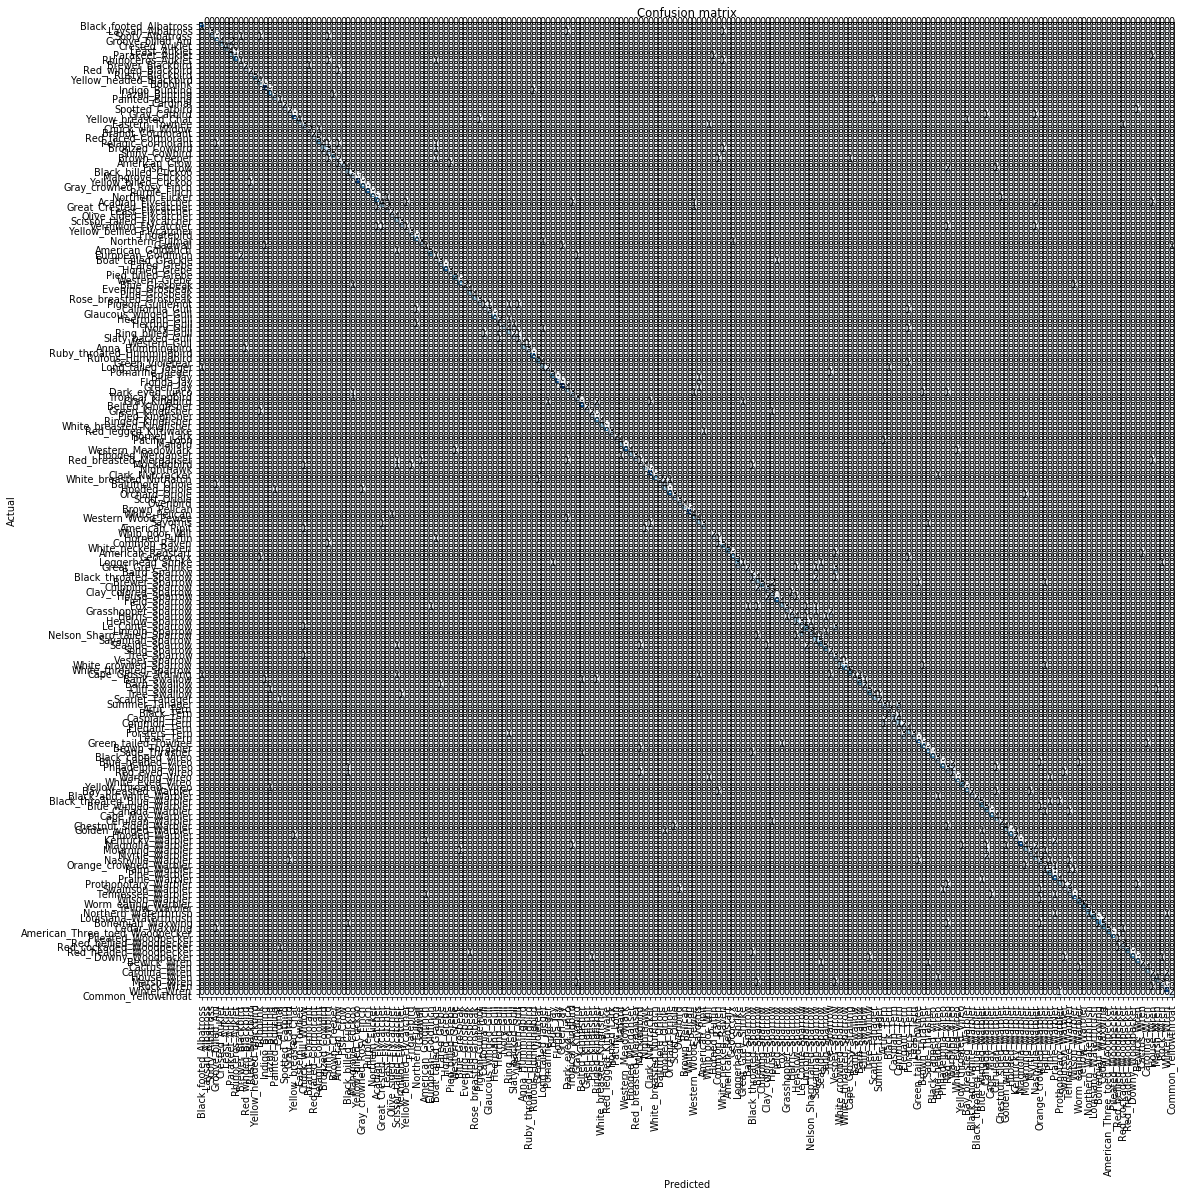

In [28]:
# show confusion matrix (note: too many classes)
interp.plot_confusion_matrix(figsize=(17,17), dpi=70)

In [29]:
# plot most confused classes (min count of 2)
interp.most_confused(min_val=2)

[('Nelson_Sharp_tailed_Sparrow', 'Le_Conte_Sparrow', 4),
 ('Great_Grey_Shrike', 'Loggerhead_Shrike', 3),
 ('Baird_Sparrow', 'Vesper_Sparrow', 3),
 ('Lincoln_Sparrow', 'Vesper_Sparrow', 3),
 ('Artic_Tern', 'Common_Tern', 3),
 ('Least_Tern', 'Elegant_Tern', 3)]

## Stage 2A - Training

In [32]:
!gpustat

psbtmxtmo  Fri Oct 26 15:03:22 2018
[0] Quadro P4000     | 39'C,   0 % |  7270 /  8119 MB | paperspace(4445M) paperspace(2815M)


In [33]:
# unfreeze the entire NN
learn.unfreeze()

In [34]:
# check if full NN is succesfull
learn.fit_one_cycle(1)

Total time: 00:31
epoch  train_loss  valid_loss  accuracy
1      2.498622    2.085963    0.472915  (00:31)



The training of the entire network results in huge accuracy decreas (approx 0.70 to 0.50).<br>
Therefore, discriminate learning rates will be used for training (see "Training - Stage 2B").

## Stage 2B - Training

In [35]:
!gpustat

psbtmxtmo  Fri Oct 26 15:05:31 2018
[0] Quadro P4000     | 59'C,  85 % |  7142 /  8119 MB | paperspace(4445M) paperspace(2687M)


In [36]:
# reload saved with from "Training - Stage 1"
learn.load('birds_resnet34_stage_1')

In [37]:
# run learning rate finder again
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


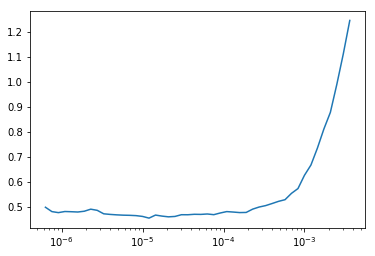

In [38]:
learn.recorder.plot()

In [39]:
# unfreez entire network again and train with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

Total time: 01:31
epoch  train_loss  valid_loss  accuracy
1      0.514599    1.008055    0.720550  (00:30)
2      0.511587    1.002729    0.717111  (00:30)
3      0.481914    1.010812    0.713672  (00:30)



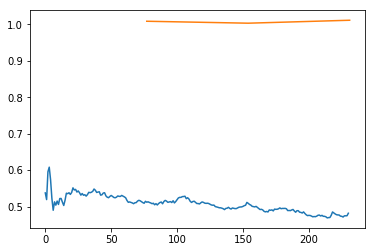

In [40]:
# plot learning
learn.recorder.plot_losses()

In [41]:
learn.fit_one_cycle(12, max_lr=slice(1e-6, 1e-4))

Total time: 06:19
epoch  train_loss  valid_loss  accuracy
1      0.497321    0.990703    0.715391  (00:30)
2      0.465006    0.999603    0.718831  (00:31)
3      0.475745    0.996729    0.723990  (00:32)
4      0.447998    0.992156    0.714531  (00:33)
5      0.465559    0.974996    0.720550  (00:30)
6      0.459495    0.979749    0.726569  (00:30)
7      0.415633    0.977557    0.730868  (00:32)
8      0.389075    0.967526    0.731728  (00:31)
9      0.399469    0.974801    0.722270  (00:33)
10     0.384172    0.968893    0.723990  (00:30)
11     0.391881    0.971023    0.734308  (00:32)
12     0.368272    0.971073    0.727429  (00:30)



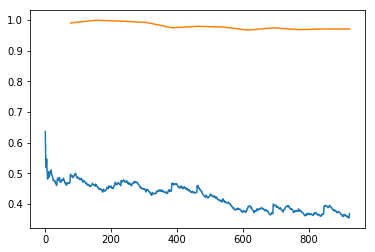

In [42]:
learn.recorder.plot_losses()

In [44]:
learn.save('birds_resnet34_stage_2b')

<font color=red> Note: The interpretation of the training and validation losses as well as the plots need further investigation (see warning at the begining).</font>